# Automatic Ticket Assignment - Capstone Project - Approach2

## Problem Statement - 

In most of the IT organizations, the assignment of incidents to appropriate IT groups is still a manual process. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

_<font color=blue>This capstone project intends to reduce the manual intervention of IT operations or Service desk teams by automating the ticket assignment process.The goal here is to create a text classification based ML model that can automatically  classify any new tickets by analysing ticket description to one of the relevant Assignment groups, which could be later integrated to any ITSM tool like Service Now. Based on the ticket description our model will output the probability of assigning it to one of the 74 Groups.</font>_

The solution would be implemented using below approach:

In the AS-IS process it's mentioned that around ~54% of the incidents are resolved by L1 / L2 teams and the rest will be resolved as L3. So the assumption is that GRP_0 and GRP_8 which contribute 54% of the tickets are related to L1/L2 teams and the rest of the tickets belongs to L3 teams

So firstly, the ticket would be classified into L1/L2 or L3 classes and then it would be further classified into one of the given assignment groups. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/projects/AutoTicketAssignment/

/content/drive/MyDrive/projects/AutoTicketAssignment


### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings('ignore')

### Load the preprocessed dataset

In [ ]:
df_incidents_level = pd.read_csv('processed_file_modellling.csv',encoding='utf-8')
df_incidents_level.head()

,Assignment group,cleaned_description,num_wds,avg_word,uniq_wds,token_desc,Target
0,GRP_0,login issue verified user detailsemployee mana...,19,7.157895,16,login issue verified user detailsemployee mana...,L1/L2
1,GRP_0,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,13,7.538462,12,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,L1/L2
2,GRP_0,cant log vpn eylqgodmybqkwiami cannot log vpn,7,5.571429,5,cant log vpn eylqgodmybqkwiami cannot log vpn,L1/L2
3,GRP_0,unable access hrtool page unable access hrtool...,8,5.500000,4,unable access hrtool page unable access hrtool...,L1/L2
4,GRP_0,skype error skype error,4,5.000000,2,skype error skype error,L1/L2


Since the dataset is very imbalanced, we will be considering a subset of groups for predictions. In 74 groups, 46% of tickets belong to group 1 and 16 groups have more than 100 tickets and around 22 groups have more than 50 tickets, rest of the Assignment groups have very less ticket counts which might not add much value to the model prediction. If we conducted random sampling towards all the subcategories, then we would face a problem that we might miss all the tickets in some categories. Hence, we considered the groups that have more than 50 tickets in this appoach

In [ ]:
df_incidents_level.rename(columns={'Assignment group': 'Assignment_group'}, inplace=True)

In [ ]:
df_incidents_level = df_incidents_level[df_incidents_level['Assignment_group'].map(df_incidents_level['Assignment_group'].value_counts()) > 50]
x = df_incidents_level['token_desc']
y = df_incidents_level['Target']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
    
log_cols=["Classifier", "accuracy","f1_score"]
log1 = pd.DataFrame(columns=log_cols)

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Modeling

Pass the data to various models which learns to classify the tickets into one of the two groups -  L1/L2 or L3 class

#### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)

accuracy 0.5618122977346278
f1 score 0.6216366968921104
logloss: 0.699 
              precision    recall  f1-score   support

           0       0.57      0.87      0.69       850
           1       0.54      0.19      0.28       695

    accuracy                           0.56      1545
   macro avg       0.55      0.53      0.48      1545
weighted avg       0.55      0.56      0.50      1545

[[738 112]
 [565 130]]


#### Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))
log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)

accuracy 0.5300970873786408
f1 score 0.5289222313696916
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       850
           1       0.48      0.53      0.50       695

    accuracy                           0.53      1545
   macro avg       0.53      0.53      0.53      1545
weighted avg       0.53      0.53      0.53      1545

[[452 398]
 [328 367]]


#### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)

accuracy 0.5339805825242718
f1 score 0.5399247317814854
              precision    recall  f1-score   support

           0       0.61      0.42      0.50       850
           1       0.49      0.67      0.57       695

    accuracy                           0.53      1545
   macro avg       0.55      0.55      0.53      1545
weighted avg       0.56      0.53      0.53      1545

[[356 494]
 [226 469]]


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)

accuracy 0.5029126213592233
f1 score 0.5017719754539705
logloss: 3.156 
              precision    recall  f1-score   support

           0       0.55      0.52      0.53       850
           1       0.45      0.49      0.47       695

    accuracy                           0.50      1545
   macro avg       0.50      0.50      0.50      1545
weighted avg       0.51      0.50      0.50      1545

[[439 411]
 [357 338]]


In [ ]:
log1.set_index(["Classifier"],inplace=True)
log1.sort_values(by=['f1_score'])

,accuracy,f1_score
Classifier,,
LogisticRegression,0.502913,0.501772
LinearSVC,0.530097,0.528922
SGDClassifier,0.533981,0.539925
MultinomialNB,0.561812,0.621637


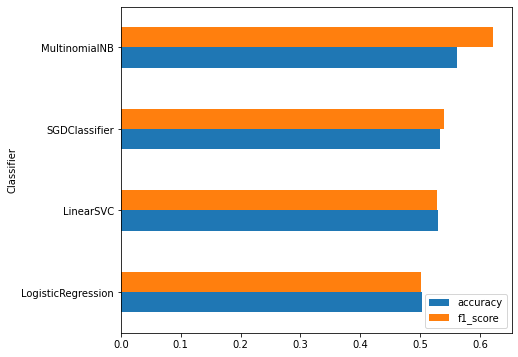

In [ ]:
log1.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])

Linear SVC gives better performance compared to other models

In [ ]:
### Save the model
from sklearn.externals import joblib
joblib.dump(svc, 'l1_l2_classification.pkl', compress=1)

['l1_l2_classification.pkl']

In [ ]:
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
le_name_mapping

{'L1/L2': 0, 'L3': 1}

In [ ]:
from sklearn.externals import joblib
model = joblib.load('l1_l2_classification.pkl')

sentence = 'job failed in scheduler'
encoder.inverse_transform(model.predict([sentence]))

array(['L3'], dtype=object)

## Model1 - Classification of L1/L2 tickets between GRP0 and GRP8

In [ ]:
df_incidents_l1_l2 = df_incidents_level[df_incidents_level['Target'] == 'L1/L2']
df_incidents_l1_l2.shape

(4248, 7)

In [ ]:
df_incidents_l1_l2.Assignment_group.value_counts()

GRP_0     2437
GRP_8      374
GRP_24     144
GRP_12     134
GRP_9      115
GRP_2      100
GRP_19      99
GRP_3       89
GRP_6       84
GRP_13      74
GRP_10      65
GRP_14      64
GRP_25      54
GRP_4       50
GRP_5       47
GRP_33      46
GRP_17      42
GRP_29      41
GRP_16      39
GRP_7       37
GRP_18      31
GRP_34      29
GRP_26      27
GRP_31      26
Name: Assignment_group, dtype: int64

In [ ]:
x = df_incidents_l1_l2['token_desc']
y = df_incidents_l1_l2['Assignment_group']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
    
log_cols=["Classifier", "accuracy","f1_score"]
log2 = pd.DataFrame(columns=log_cols)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)
predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)

accuracy 0.6647058823529411
f1 score 0.7888738326389686
logloss: 1.591 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       488
           1       0.00      0.00      0.00        13
           2       0.80      0.15      0.25        27
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        20
          10       1.00      0.10      0.19        29
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00         5
         

### Linear Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('Test accuracy %s' % accuracy_score(y_pred, y_test))
print('Test f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)

Test accuracy 0.6858823529411765
Test f1 score 0.6848344421994538
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       488
           1       0.50      0.23      0.32        13
           2       0.50      0.70      0.58        27
           3       0.59      0.67      0.62        15
           4       0.44      0.31      0.36        13
           5       0.00      0.00      0.00         8
           6       0.89      1.00      0.94         8
           7       0.67      0.33      0.44         6
           8       0.28      0.25      0.26        20
           9       0.53      0.40      0.46        20
          10       0.83      0.83      0.83        29
          11       0.50      0.27      0.35        11
          12       0.00      0.00      0.00         5
          13       0.62      0.62      0.62         8
          14       0.29      0.39      0.33        18
          15       0.50      0.40      0.44         5
          16   

### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)




y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)

accuracy 0.5411764705882353
f1 score 0.49356516447305127
              precision    recall  f1-score   support

           0       0.94      0.62      0.74       488
           1       0.08      0.54      0.13        13
           2       0.41      0.48      0.44        27
           3       0.45      0.67      0.54        15
           4       0.47      0.69      0.56        13
           5       0.17      0.62      0.26         8
           6       0.57      1.00      0.73         8
           7       0.18      0.50      0.26         6
           8       0.31      0.25      0.28        20
           9       0.33      0.45      0.38        20
          10       0.67      0.76      0.71        29
          11       0.26      0.64      0.37        11
          12       0.13      0.40      0.20         5
          13       0.32      0.75      0.44         8
          14       0.25      0.39      0.30        18
          15       0.16      0.60      0.25         5
          16       0.33 

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)

accuracy 0.6929411764705883
f1 score 0.7023237025586234
logloss: 1.597 
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       488
           1       0.67      0.31      0.42        13
           2       0.44      0.74      0.56        27
           3       0.77      0.67      0.71        15
           4       0.55      0.46      0.50        13
           5       0.00      0.00      0.00         8
           6       0.88      0.88      0.88         8
           7       0.60      0.50      0.55         6
           8       0.33      0.35      0.34        20
           9       0.36      0.40      0.38        20
          10       0.82      0.79      0.81        29
          11       0.75      0.27      0.40        11
          12       0.00      0.00      0.00         5
          13       0.33      0.12      0.18         8
          14       0.35      0.33      0.34        18
          15       0.25      0.40      0.31         5
         

In [ ]:
log2.set_index(["Classifier"],inplace=True)
log2.sort_values(by=['f1_score'])

,accuracy,f1_score
Classifier,,
SGDClassifier,0.541176,0.493565
LinearSVC,0.685882,0.684834
LogisticRegression,0.692941,0.702324
MultinomialNB,0.664706,0.788874


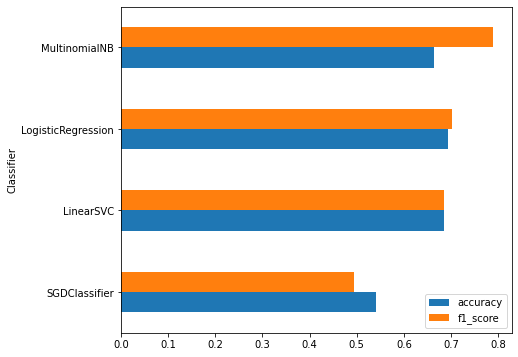

In [ ]:
log2.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])

In [ ]:

### Save the model
from sklearn.externals import joblib
joblib.dump(logreg_1, 'model_l1_l2.pkl', compress=1)

['model_l1_l2.pkl']

In [ ]:
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
le_name_mapping

{'GRP_0': 0,
 'GRP_10': 1,
 'GRP_12': 2,
 'GRP_13': 3,
 'GRP_14': 4,
 'GRP_16': 5,
 'GRP_17': 6,
 'GRP_18': 7,
 'GRP_19': 8,
 'GRP_2': 9,
 'GRP_24': 10,
 'GRP_25': 11,
 'GRP_26': 12,
 'GRP_29': 13,
 'GRP_3': 14,
 'GRP_31': 15,
 'GRP_33': 16,
 'GRP_34': 17,
 'GRP_4': 18,
 'GRP_5': 19,
 'GRP_6': 20,
 'GRP_7': 21,
 'GRP_8': 22,
 'GRP_9': 23}

In [ ]:

from sklearn.externals import joblib
model = joblib.load('model_l1_l2.pkl')

sentence = 'job failed in scheduler'
encoder.inverse_transform(model.predict([sentence]))

array(['GRP_5'], dtype=object)

## Model to classify L3 tickets

Lets's now train the models to classify the L3 tickets into one of the assignement groups.

In [ ]:
df_incidents_l3 = df_incidents_level[df_incidents_level['Target'] == 'L3']
df_incidents_l3 = df_incidents_l3[df_incidents_l3['Assignment_group'].map(df_incidents_l3['Assignment_group'].value_counts()) > 50]
x = df_incidents_l3['token_desc']
y = df_incidents_l3['Assignment_group']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
log_cols=["Classifier", "accuracy","f1_score"]
log = pd.DataFrame(columns=log_cols)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)
predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.5816485225505443
f1 score 0.7132671735077503
logloss: 1.526 
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       308
           1       0.00      0.00      0.00        15
           2       1.00      0.20      0.33        25
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        23
           7       0.67      0.07      0.13        28
           8       1.00      0.28      0.43        29
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        20
          15       0.49      0.88      0.63        58
         

### Linear Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('Test accuracy %s' % accuracy_score(y_pred, y_test))
print('Test f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

Test accuracy 0.6671850699844479
Test f1 score 0.669417117147617
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       308
           1       0.50      0.33      0.40        15
           2       0.70      0.76      0.73        25
           3       0.90      0.64      0.75        14
           4       0.33      0.18      0.24        11
           5       0.78      0.64      0.70        11
           6       0.25      0.30      0.27        23
           7       0.41      0.43      0.42        28
           8       0.84      0.90      0.87        29
           9       0.67      0.67      0.67        12
          10       0.60      0.55      0.57        11
          11       0.38      0.23      0.29        22
          12       0.64      0.58      0.61        12
          13       0.33      0.06      0.11        16
          14       0.20      0.90      0.33        20
          15       0.95      0.34      0.51        58
          16    

### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.6236391912908242
f1 score 0.6191631913481135
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       308
           1       0.14      0.20      0.16        15
           2       0.58      0.76      0.66        25
           3       0.47      0.64      0.55        14
           4       0.20      0.18      0.19        11
           5       0.31      0.73      0.43        11
           6       0.33      0.43      0.38        23
           7       0.41      0.46      0.43        28
           8       0.62      0.86      0.72        29
           9       0.52      1.00      0.69        12
          10       0.33      0.55      0.41        11
          11       0.33      0.27      0.30        22
          12       0.41      0.75      0.53        12
          13       0.33      0.06      0.11        16
          14       0.80      0.40      0.53        20
          15       0.51      0.79      0.62        58
          16       0.62  

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)

accuracy 0.6594090202177294
f1 score 0.6593670411339798
logloss: 1.675 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       308
           1       0.50      0.20      0.29        15
           2       0.67      0.56      0.61        25
           3       0.75      0.64      0.69        14
           4       0.60      0.27      0.37        11
           5       0.83      0.45      0.59        11
           6       0.26      0.30      0.28        23
           7       0.46      0.43      0.44        28
           8       0.76      0.90      0.83        29
           9       0.89      0.67      0.76        12
          10       0.62      0.45      0.53        11
          11       0.53      0.41      0.46        22
          12       0.57      0.67      0.62        12
          13       0.19      0.88      0.31        16
          14       0.47      0.45      0.46        20
          15       0.95      0.36      0.53        58
         

In [ ]:
log.set_index(["Classifier"],inplace=True)
log.sort_values(by=['f1_score'])

,accuracy,f1_score
Classifier,,
SGDClassifier,0.623639,0.619163
LogisticRegression,0.659409,0.659367
LinearSVC,0.667185,0.669417
MultinomialNB,0.581649,0.713267


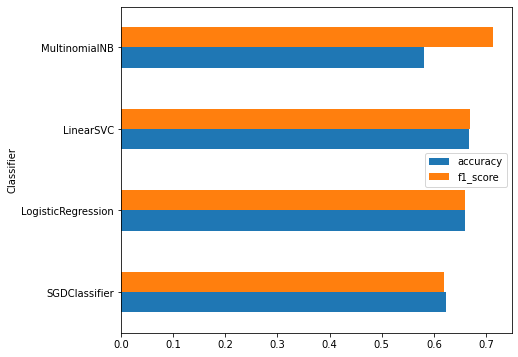

In [ ]:
log.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])

## Hyperparameter Tune GridSearchCV 

Let's tune each of the models using GridsearchCV to identify the best parameters

### Linear SVC

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"clf__estimator__C": [0.1, 1, 10, 100, 1000],  
              'clf__estimator__loss': ['hinge','squared_hinge'],}  
  
clf_svc = GridSearchCV(svc, param_grid=params, refit = True, verbose = 1,scoring='f1_weighted') 
# fitting the model for grid search 
clf_svc.fit(X_train, y_train)

print("Best Score: ", clf_svc.best_score_)
print("Best Params: ", clf_svc.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.2s finished


Best Score:  0.6676060726042718
Best Params:  {'clf__estimator__C': 1, 'clf__estimator__loss': 'hinge'}


In [ ]:
y_pred = clf_svc.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['LinearSVC_best_estimator'])
log = log.append(log_entry)

accuracy 0.6671850699844479
f1 score 0.669417117147617
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       308
           1       0.50      0.33      0.40        15
           2       0.70      0.76      0.73        25
           3       0.90      0.64      0.75        14
           4       0.33      0.18      0.24        11
           5       0.78      0.64      0.70        11
           6       0.25      0.30      0.27        23
           7       0.41      0.43      0.42        28
           8       0.84      0.90      0.87        29
           9       0.67      0.67      0.67        12
          10       0.60      0.55      0.57        11
          11       0.38      0.23      0.29        22
          12       0.64      0.58      0.61        12
          13       0.33      0.06      0.11        16
          14       0.20      0.90      0.33        20
          15       0.95      0.34      0.51        58
          16       0.73   

### SGD Classifier

In [ ]:

params = {
    "clf__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "none"],
}

clf_sgd = GridSearchCV(sgd, param_grid=params,refit = True, verbose = 1,scoring='f1_weighted')
clf_sgd.fit(X_train, y_train)

print("Best Score: ", clf_sgd.best_score_)
print("Best Params: ", clf_sgd.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.7min finished


Best Score:  0.6636979641698132
Best Params:  {'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__penalty': 'l2'}


In [ ]:
y_pred = clf_sgd.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGD_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['SGD_best_estimator'])
log = log.append(log_entry)

accuracy 0.6547433903576982
f1 score 0.6546864611127663
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       308
           1       0.57      0.27      0.36        15
           2       0.67      0.64      0.65        25
           3       0.69      0.64      0.67        14
           4       0.33      0.18      0.24        11
           5       0.64      0.64      0.64        11
           6       0.29      0.35      0.31        23
           7       0.40      0.50      0.44        28
           8       0.74      0.90      0.81        29
           9       0.62      0.83      0.71        12
          10       0.50      0.55      0.52        11
          11       0.29      0.23      0.26        22
          12       0.56      0.75      0.64        12
          13       0.33      0.06      0.11        16
          14       0.50      0.45      0.47        20
          15       1.00      0.36      0.53        58
          16       0.24  

### Logistic Regression

In [ ]:
params = {
  'clf__penalty': ['l2'],
  'clf__C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0,1e2,1e4,1e5],
  'clf__max_iter': [100,4000,5000],
}

clf_lr = GridSearchCV(logreg_1, param_grid=params,refit = True,verbose = 1,scoring='f1_weighted')
clf_lr.fit(X_train, y_train)

print("Best Score: ", clf_lr.best_score_)
print("Best Params: ", clf_lr.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 18.2min finished


Best Score:  0.6530367667820494
Best Params:  {'clf__C': 100.0, 'clf__max_iter': 4000, 'clf__penalty': 'l2'}


In [ ]:
y_pred = clf_lr.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['LogisticRegression_best_estimator'])
log = log.append(log_entry)

accuracy 0.6625194401244168
f1 score 0.6544892649396113
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       308
           1       0.56      0.33      0.42        15
           2       0.72      0.72      0.72        25
           3       0.90      0.64      0.75        14
           4       0.43      0.27      0.33        11
           5       0.67      0.55      0.60        11
           6       0.29      0.35      0.31        23
           7       0.39      0.46      0.43        28
           8       0.76      0.90      0.83        29
           9       0.82      0.75      0.78        12
          10       0.55      0.55      0.55        11
          11       0.39      0.41      0.40        22
          12       0.62      0.67      0.64        12
          13       0.18      0.81      0.30        16
          14       0.47      0.45      0.46        20
          15       1.00      0.34      0.51        58
          16       0.73  

In [ ]:
log.sort_values(by=['f1_score'])

,accuracy,f1_score,Classifier
SGDClassifier,0.623639,0.619163,NaN
LogisticRegression_best_estimator,0.662519,0.654489,LogisticRegression_best_estimator
SGD_best_estimator,0.654743,0.654686,SGD_best_estimator
LogisticRegression,0.659409,0.659367,NaN
LinearSVC,0.667185,0.669417,NaN
LinearSVC_best_estimator,0.667185,0.669417,LinearSVC_best_estimator
MultinomialNB,0.581649,0.713267,NaN


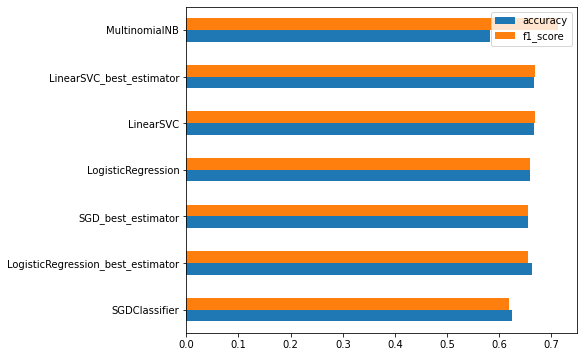

In [ ]:
log.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])

## Keras implementation

In [ ]:
from tensorflow import keras


class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return reduced_fl

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import tensorflow as tf

x = df_incidents_l3['token_desc']
y = df_incidents_l3['Assignment_group']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=13,stratify=y)

num_labels = 22
vocab_size = 50000
batch_size = 64
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
 
x_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = Sequential()
model.add(Dense(50, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss=FocalLoss(alpha=1),
              optimizer='nadam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,validation_split=0.2,callbacks=[es_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2500050   
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                6

ValueError: ignored

In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])

In [ ]:

### Save the model
from sklearn.externals import joblib
joblib.dump(clf_lr.best_estimator_, 'model_l3.pkl', compress=1)

['model_l3.pkl']

# Finals Conclusions fo Approach2

- We first analysed the dataset provided to us, undestood the structure of the data provided - number of columns, field , datatypes etc.
- We did Exploratory Data Analysis to derive further insights from this data set and we found that
    - Data is very much imbalanced, there are around ~45% of the Groups with less than 20 tickets.
    - Few of the tickets are in foreign language like German
    - The data has lot of noise in it, for eg- few tickets related to account setup are spread across multiple assignment groups.
    
- We performed the data cleaning and preprocessing
    - Translation: A small number of tickets were written in German. Hence, we used the Google translate python api  to convert German to English to generate the input data for the next steps. However, the google translator rest api can only process a limited number of texts on a daily basis, so we translated the text in batches and saved the file for further processing.
    - Make text all lowercase so that the algorithm does not treat the same words in different cases as different
    - Removing Noise i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values
    - Removing extract spaces
    - Removed punctuations
    - Removed words containing numbers
    - Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words
    - Lemmatization
    - Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
    

- We then ran a basic benchmarck model using the cleaned and preprocessed dataset
    - Since the dataset is very imbalanced, We considered a subset of groups for predictions.  In 74 groups, 46% of tickets belong to group 1 and 16 groups just have more than 100 tickets, rest of the Assignment groups have very less ticket counts which might not add much value to the model prediction. If we conducted random sampling towards all the subcategories, then we would face a problem that we might miss all the tickets in some categories. Hence, we considered the groups that have more than 100 tickets. 
    - We trained the data using below models:
        - Multinomial NB
        - Linear Support vector Machine
        - Logistic regression
        - Xgboost
        
-  LinearSVC gives better performance with 
    accuracy 0.833642
    f1 score 0.818053

<b> Although, it seems like the call is biased towards GRP_0 which has a majority of samples. </b>





- Even after downsampling the data we see that the predictions are biased towards GRP_0 which has a majority of samples.
- Imbalance causes two problems:
    - Training is inefficient as most samples are easy examples that contribute no useful learning signal;
    - The easy examples can overwhelm training and lead to degenerate models.
    A common solution is to perform some form of hard negative mining that samples hard examples during training or more complex sampling/re weighing schemes.In order to handle the imbalance problem  we used class_weight=balanced hyperparameter while training the model, which tells the model to "pay more attention" to samples from an under-represented class.  
- Although, the accuracy and f1_score went down. This ensured that the classes were being correctly classified with lesser number of missclassification and good precision/recall scores for all the classes

- Next, we used Approach 2 where the ticket would be classified into L1/L2 or L3 classes and then it would be further classified into one of the given assignment groups. 

- We first created a model to classify the given tickets as l1/l2 or l3 ticket, we found that Linear SVC was giving a better score.
- Next, another model was trained considering only l1/l2 level of incidents consisting of GRP_0 and GRP_8.
- Finally, a third model was trained considering l3 level of tickets.

- We also used hyperparameter tuning, to identify the best classifier with best parameters. We found that LinearSVC was performing the best among all the other classifiers.
- We also tried keras implementation with focal loss as a loss function to handle the class imbalance problem, which helps in giving more weightage to groups will less samples, but the results were not satifactory.
  
 - Finally, Logistic Regression gave better performance with hyperparameter tuning and this model would be used for classifying the L3 tickets into one of the groups.
    - accuracy 0.706260
    - f1 score 0.705392


The performance can be further improved by collecting more data for tickets and by running deep learning models like RNN and LSTM's.